In [1]:
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping

### 1. 데이터 불러오기

In [63]:
file_path = "/content/sample_data/ChatbotData.csv"

In [64]:
data = pd.read_csv(file_path)#데이터 로드
data = data[['Q', 'A']]
data = data.dropna()
print(data.head())

                 Q            A
0           12시 땡!   하루가 또 가네요.
1      1지망 학교 떨어졌어    위로해 드립니다.
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.
4          PPL 심하네   눈살이 찌푸려지죠.


In [65]:
data.isna().sum()

print("총 데이터 수 :", len(data))
data_list = data.values.tolist()
print(data_list[:5])

총 데이터 수 : 11823
[['12시 땡!', '하루가 또 가네요.'], ['1지망 학교 떨어졌어', '위로해 드립니다.'], ['3박4일 놀러가고 싶다', '여행은 언제나 좋죠.'], ['3박4일 정도 놀러가고 싶다', '여행은 언제나 좋죠.'], ['PPL 심하네', '눈살이 찌푸려지죠.']]


### 2. 데이터 전처리 하기

In [66]:
#전처리 함수
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^a-zA-Z?.!,0-9가-힣]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [67]:
questions = data["Q"].apply(preprocess_sentence).tolist()
answers = data["A"].apply(preprocess_sentence).tolist()

print('전처리 후의 1000번째 질문 샘플: {}'.format(questions[1000]))
print('전처리 후의 1000번째 답변 샘플: {}'.format(answers[1000]))

전처리 후의 1000번째 질문 샘플: 노래방 걸 거 같은데 뭐 부르지
전처리 후의 1000번째 답변 샘플: 달달한 노래요 .


### 3. SubwordTextEncoder

In [68]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13
)

# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print('vocab size :', [tokenizer.vocab_size])
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

vocab size : [8162]
START_TOKEN의 번호 : [8162]
END_TOKEN의 번호 : [8163]
8164


### 4. 각 단어를 고유한 정수로 인코딩 하고 패딩하기

In [69]:
# 임의의 1000번째 샘플에 대해서 토큰화 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('토큰화 후의 1000번째 질문 샘플: {}'.format(tokenizer.encode(questions[1000])))
print('토큰화 후의 1000번째 답변 샘플: {}'.format(tokenizer.encode(answers[1000])))

# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 20 ## 15 <- 40

토큰화 후의 1000번째 질문 샘플: [2120, 85, 8, 444, 156, 2301, 47]
토큰화 후의 1000번째 답변 샘플: [3629, 1346, 17, 1]


In [70]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # 최대 길이 40->15으로 모든 데이터셋을 패딩 -> postd와 pre 중 실험 해볼 것
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post'
    )
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post'
    )

    return tokenized_inputs, tokenized_outputs


In [71]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8164
필터링 후의 질문 샘플 개수: 11792
필터링 후의 답변 샘플 개수: 11792


### 5. Teacher Forcing 사용하기

In [72]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

## 데이터가 디스크에서 한 번만 로드되도록 하여 성능을 향상
dataset = dataset.cache()

## BUFFER_SIZE만큼 데이터를 섞음
dataset = dataset.shuffle(BUFFER_SIZE)

## BATCH_SIZE만큼의 샘플로 묶음
dataset = dataset.batch(BATCH_SIZE)

## 모델이 학습을 하는 동안 다음 배치를 미리 준비
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

### 6. Model 구성하기

Positional Encoding Layer

In [73]:

## 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    ## 각도 배열 생성
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model
        )

        ## 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])

        ## 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        ## sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0])
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])
        pos_encoding = pos_encoding[tf.newaxis, ...]

        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

Scaled Dot Product Attention

In [74]:
## 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    ## 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    ## 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    ## 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    ## softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    ## 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)

    return output

Multi Head Attention

In [75]:
## MultiHeadAttention 구현
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads ## multi heads 수
        self.d_model = d_model ## embedding layer 수

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth)
            )
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

Masking

In [76]:
## Padding Masking
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)

    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

## Look-ahead masking
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)

    return tf.maximum(look_ahead_mask, padding_mask)

Encoder

In [77]:
#인코더 레이어
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)



#인코더
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


Decoder

In [78]:
#디코더 레이어

# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

#디코더

def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


Transformer

In [79]:
def transformer(
    vocab_size,
    num_layers,
    units,
    d_model,
    num_heads,
    dropout,
    name="transformer"
   ):
    ## encoder input & decoder input
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    ## 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask'
        )(inputs)

    ## 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    ## 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask'
        )(dec_inputs)

    ## 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    ## 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

    ## 인코더
    enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    ## 디코더
    dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    ## 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### 6. 모델 생성하기

Hyperparameter

In [106]:
tf.keras.backend.clear_session()

## 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 2048 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.15 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, None)]               0         []                            
                                                                                                  
 dec_inputs (InputLayer)     [(None, None)]               0         []                            
                                                                                                  
 enc_padding_mask (Lambda)   (None, 1, 1, None)           0         ['inputs[0][0]']              
                                                                                                  
 encoder (Functional)        (None, None, 512)            2309427   ['inputs[0][0]',              
                                                          2          'enc_padding_mask[0

Loss Function

In [82]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask) ## padding 부분은 빼고 loss를 계산한다?

    return tf.reduce_mean(loss)

Learning Rate

In [56]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Model Compile

In [60]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

### 7. Training Model

In [99]:

history = model.fit(
    dataset,
    epochs=30,
    verbose=1,
)

Epoch 1/30
185/185 [==============================] - 200s 921ms/step - loss: 2.7264 - accuracy: 0.0531
Epoch 2/30
185/185 [==============================] - 167s 904ms/step - loss: 2.1726 - accuracy: 0.1017
Epoch 3/30
185/185 [==============================] - 169s 912ms/step - loss: 1.9957 - accuracy: 0.1043
Epoch 4/30
185/185 [==============================] - 168s 907ms/step - loss: 1.9101 - accuracy: 0.1089
Epoch 5/30
185/185 [==============================] - 168s 908ms/step - loss: 1.8378 - accuracy: 0.1132
Epoch 6/30
185/185 [==============================] - 167s 902ms/step - loss: 1.7754 - accuracy: 0.1161
Epoch 7/30
185/185 [==============================] - 167s 904ms/step - loss: 1.7126 - accuracy: 0.1191
Epoch 8/30
185/185 [==============================] - 167s 902ms/step - loss: 1.6522 - accuracy: 0.1223
Epoch 9/30
185/185 [==============================] - 167s 904ms/step - loss: 1.5915 - accuracy: 0.1250
Epoch 10/30
185/185 [==============================] - 167s 902m

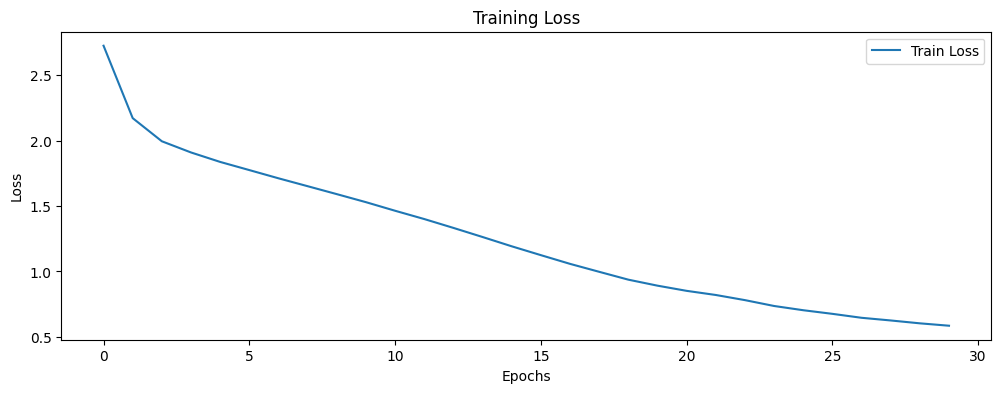

In [100]:
## loss 시각화
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### 8. Model Evaluation

In [101]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    ## 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    ## ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    ## 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    ## 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    ## 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        ## 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        ## 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        ## 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        ## 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        ## 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

### 9. Try Conversation

In [102]:
def sentence_generation(sentence):
    ## 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    ## 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [103]:
sentence_generation('컴퓨터가 망가졌어')

입력 : 컴퓨터가 망가졌어
출력 : 잘 찾아보세요 .


'잘 찾아보세요 .'

In [104]:
sentence_generation('알고리즘이 아까는 잘 됐는데 갑자기 안돼')

입력 : 알고리즘이 아까는 잘 됐는데 갑자기 안돼
출력 : 다른 사람 말은 한 귀로 흘리세요 .


'다른 사람 말은 한 귀로 흘리세요 .'

In [113]:
sentence_generation('사랑해')

입력 : 사랑해
출력 : 그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니


'그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니'

In [107]:
sentence_generation('혹시 여기 무간지옥이야?')

입력 : 혹시 여기 무간지옥이야?
출력 : 변화도 변화도 변화도 변화도 변화도 변화도 변화도 변화도 변화도 변화도 변화도 변화도 변화도 변화도 변화도 변화도 변화도 변화도 변화도 변화도 


'변화도 변화도 변화도 변화도 변화도 변화도 변화도 변화도 변화도 변화도 변화도 변화도 변화도 변화도 변화도 변화도 변화도 변화도 변화도 변화도 '

In [108]:
sentence_generation('뭐야? 엄청 무섭다 ㄷㄷ')

입력 : 뭐야? 엄청 무섭다 ㄷㄷ
출력 : 그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니


'그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니'

In [109]:
sentence_generation('그러는 이유가 뭐야')

입력 : 그러는 이유가 뭐야
출력 : 그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니


'그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니그러니'

In [111]:
sentence_generation('제주도 빨리 가고 싶다.')

입력 : 제주도 빨리 가고 싶다.
출력 : 졌다졌다졌다졌다졌다졌다졌다그러니그러니그러니그러니졌다졌다졌다졌다졌다졌다졌다그러니


'\x14졌다졌다졌다졌다졌다졌다졌다그러니그러니그러니그러니졌다졌다졌다졌다졌다졌다졌다그러니'

In [112]:
sentence_generation('물건이 망가졌어')

입력 : 물건이 망가졌어
출력 : 로부터 로부터 로부터 로부터 로부터 부족한가로부터 부족한가부족한가부족한가부족한가부족한가부족한가부족한가부족한가부족한가부족한가부족한가부족한가부족한가


'로부터 로부터 로부터 로부터 로부터 부족한가로부터 부족한가부족한가부족한가부족한가부족한가부족한가부족한가부족한가부족한가부족한가부족한가부족한가부족한가'

- 회고

왜 잘 되던것도 런타임이 끊기고 나서 다시 돌리면 안되는 걸까? 실행하는 순서에 따라 문제가 생길 수 있어서 순서에 따라서 코드를 작성하고 있는데... 아까 잘 되었던 것을 다시 바꿀수도 없고... 다시 바꿔도 새로운 문제가 생겨나고...
문제 가 생겼을때 해결하는 게 참 힘들다



그리고 처음 2번째는 문장의 형태로 생성이 되는 것 같은데 그 이후부터느 생성이 이상하게 되는것 같다.